In [2]:
import torch

from torch import nn, optim
from torch.nn import Sequential, RNN, LSTM, Linear, ReLU, Sequential
from torch.utils.data import  DataLoader
from matplotlib import pyplot as plt


from dataset import EarthSystemsDataset 
from nn_util import EarthSystemsRNN, Trainer

## Reccurent Neural Network (RNN)

In [3]:
def rnn_layers1(in_size, label_size, lags):
    # in_size is number of variables
    h_size1 = 100
    h_size2 = 250
    h_size3 = 400

    rnn_layers = [
        LSTM(in_size, h_size1, batch_first=True, num_layers=1),
        LSTM(h_size1, h_size2, batch_first=True, num_layers=1),
        LSTM(h_size2, h_size3, batch_first=True, num_layers=1)

        # Flatten(),
    ]

    fc_layers = [
        ReLU(),
        Linear(lags*h_size3, (lags*h_size3)//4),
        ReLU(),
        Linear((lags*h_size3)//4, (lags*h_size3)//8),
        ReLU(),
        Linear((lags*h_size3)//8, label_size)

    ]

    return Sequential(*rnn_layers), Sequential(*fc_layers)

def rnn_layers2(in_size, label_size, lags):
    # in_size is number of variables
    h_size1 = 100
    h_size2 = 250
    h_size3 = 400
    rnn_layers = [
        LSTM(in_size, h_size1, batch_first=True, num_layers=1),
        LSTM(h_size1, h_size2, batch_first=True, num_layers=1),
        LSTM(h_size2, h_size3, batch_first=True, num_layers=1)
        # RNN(in_size*2, in_size*3, batch_first=True),
        # Flatten(),
    ]

    fc_layers = [
        Linear(h_size3, label_size)
    ]

    return Sequential(*rnn_layers), Sequential(*fc_layers)

# r = rnn_layers1(4, 1)
# a = torch.randn(40, 15, 4)
# 
# r(a)[0].shape

In [4]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU")
else:
    device = torch.device("cpu")
    print("Using CPU")

Using CPU


In [5]:
data_var_names = ['global_temp', 'elec_fossil', 'elec_clean', 'co2', 'ch4']
y_vals = ['temp_change']
lags = 24
preload = 'rnn_1_temp.pth'
save_path = None #'rnn_1_temp.pth'

data = EarthSystemsDataset(data_var_names, y_vals=y_vals, val_frac=None, lags=lags, mode='rnn')
data.train_mode()
rnn_layers, fc_layers = rnn_layers1(len(data_var_names), len(y_vals), lags)

model = EarthSystemsRNN(rnn_layers, fc_layers, last_only=False).to(device)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)

trainer = Trainer(model, loss_fn, optimizer, dataset=data, batch_size=10, save_path=save_path, 
                  preload=preload, device=device)


TRAINING OVERVIEW
-------------------------------
OPTIMIZER:
 Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 1e-05
    maximize: False
    weight_decay: 0
) 
-------------------------------
LOSS FUNCTION:
 MSELoss() 
-------------------------------
MODEL ARCHITECTURE:
 EarthSystemsRNN(
  (rnn_layers): Sequential(
    (0): LSTM(5, 100, batch_first=True)
    (1): LSTM(100, 250, batch_first=True)
    (2): LSTM(250, 400, batch_first=True)
  )
  (fc_layers): Sequential(
    (0): ReLU()
    (1): Linear(in_features=9600, out_features=2400, bias=True)
    (2): ReLU()
    (3): Linear(in_features=2400, out_features=1200, bias=True)
    (4): ReLU()
    (5): Linear(in_features=1200, out_features=1, bias=True)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
) 
-------------------------------
OTHER:
Loading saved weights from rnn_1_temp.pth
Training with batch size of 10
R

In [6]:
# trainer.run_training(10)

In [7]:
trainer.get_error('train')

0.006936335004866123

In [8]:
with torch.no_grad():
    pred_loader = DataLoader(data, batch_size=1, shuffle=False)
    pred = [data.data.reset_index()[y_vals[0]][0]]*lags + [model(X.to(device, dtype=torch.float)) for X, y in pred_loader]

C:\Users\keena\AppData\Roaming\Python\Python39\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


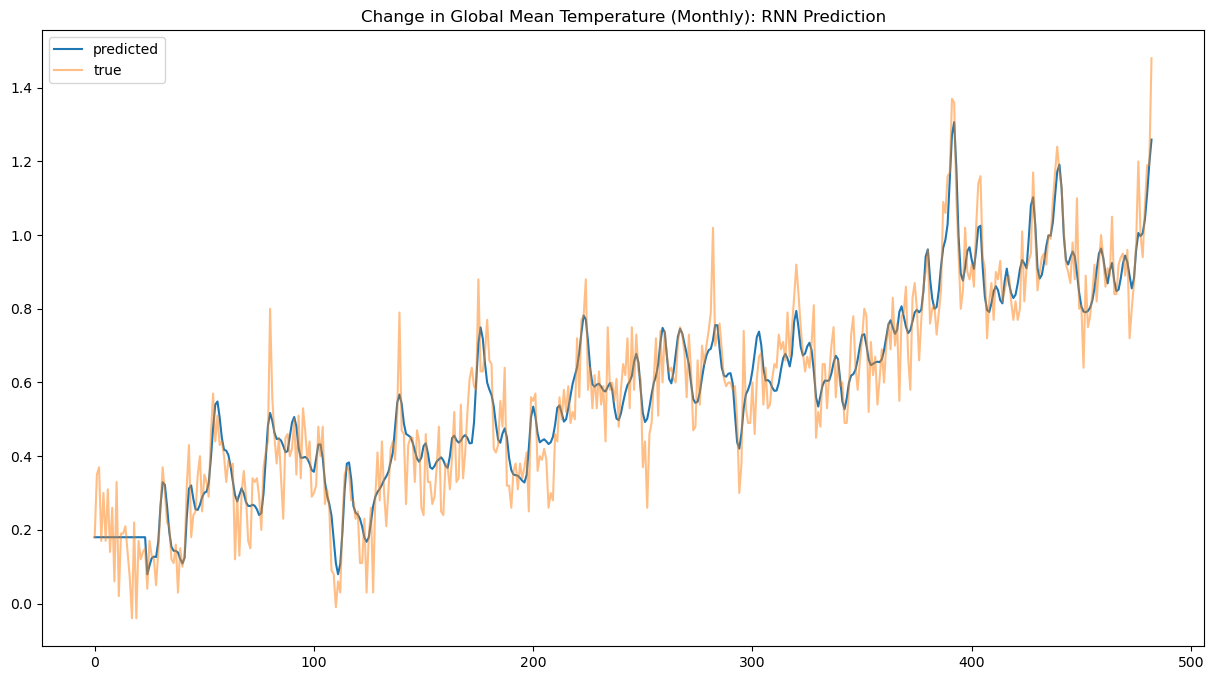

In [11]:
data.train_mode()
plt.figure(figsize=(15,8))
plt.plot(pred, label='predicted')
plt.plot(data.data.reset_index()[y_vals[0]], label='true', alpha=0.5)
plt.title('Change in Global Mean Temperature (Monthly): RNN Prediction')
plt.legend()

In [ ]:
from data import grab_dataset

<AxesSubplot:>

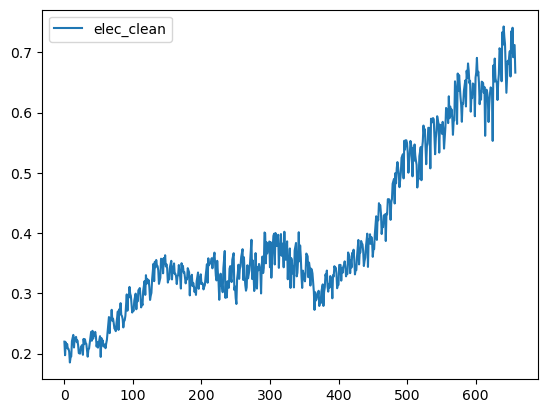

In [ ]:
a = grab_dataset('elec_clean')
a.plot(kind='line', y='elec_clean')

<AxesSubplot:>

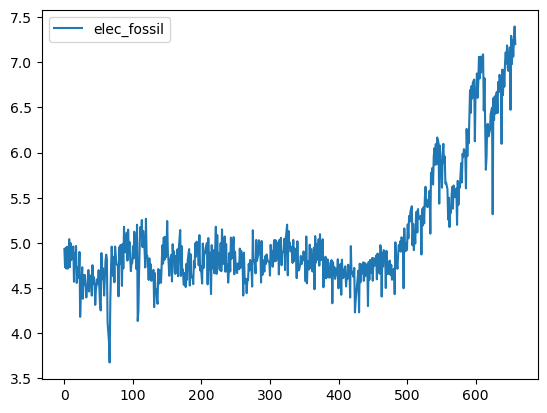

In [ ]:
b = grab_dataset('elec_fossil')
b.plot(kind='line', y='elec_fossil')